In [1]:
#Import libraries
import pandas as pd
import numpy as np

import gzip
import os
from pysam import VariantFile

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from scipy.cluster.hierarchy import dendrogram, linkage

#scikit specific imports
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from sklearn.metrics.cluster import  adjustsed_rand_score

# tensor flow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#set seed
seed = np.random.seed(808)

2024-10-16 14:41:17.364972: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 14:41:17.390192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 14:41:17.421596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 14:41:17.431255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 14:41:17.453932: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data = pd.read_csv('matrix.csv')
data.rename(columns={'Unnamed: 0': 'Sample'}, inplace = True)
data.shape

(1092, 4945)

In [3]:
data.head()

,Sample,rs144366698,rs200391621,rs78888200,rs200049935,rs182808734,rs147783986,rs202082800,rs185745570,rs151231161,...,rs6010062,rs186386126,rs73174436,rs6010073,rs181024981,rs180882000,rs147614277,rs192355741,rs191731586,Population code
0,HG00096,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GBR
1,HG00097,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,GBR
2,HG00099,0,0,1,0,0,1,0,0,0,...,1,0,0,2,0,0,1,0,0,GBR
3,HG00100,0,0,2,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,GBR
4,HG00101,0,0,1,0,0,1,0,0,0,...,2,0,0,1,0,0,0,0,0,GBR


In [4]:
non_SNP = ['Population code', 'Sample']
data_SNP = data.drop(non_SNP, axis= 1)
matrix = data_SNP.to_numpy()
print(matrix.shape)
matrix

(1092, 4943)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

### PCA

In [5]:
pca = decomposition.PCA(n_components=4)
pca.fit(matrix)


PCA(n_components=4)

In [6]:
print(pca.explained_variance_ratio_)

[0.08253525 0.05412034 0.0131711  0.00679273]


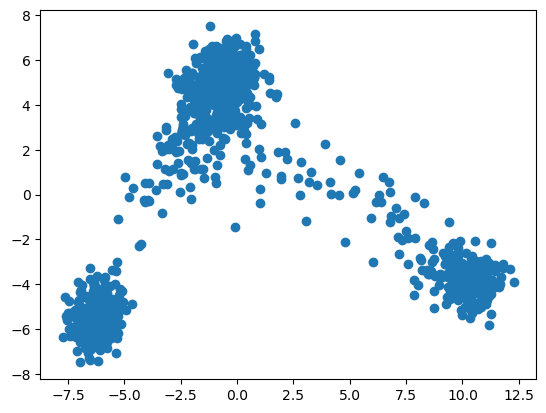

In [7]:
to_plot = pca.transform(matrix)
to_plot.shape

plt.scatter(x=to_plot[:, 0], y=to_plot[:,1])


In [8]:
df_plot = data[non_SNP].copy()
df_plot

,Population code,Sample
0,GBR,HG00096
1,GBR,HG00097
2,GBR,HG00099
3,GBR,HG00100
4,GBR,HG00101
...,...,...
1087,TSI,NA20816
1088,TSI,NA20818
1089,TSI,NA20819
1090,TSI,NA20826


In [9]:
df_plot['PC1'] = to_plot[:, 0]
df_plot['PC2'] = to_plot[:, 1]
df_plot.head()

,Population code,Sample,PC1,PC2
0,GBR,HG00096,0.312827,5.354349
1,GBR,HG00097,-0.679403,6.183329
2,GBR,HG00099,-0.420710,5.266720
3,GBR,HG00100,-0.805419,5.965095
4,GBR,HG00101,-0.771385,4.332076


### K-means

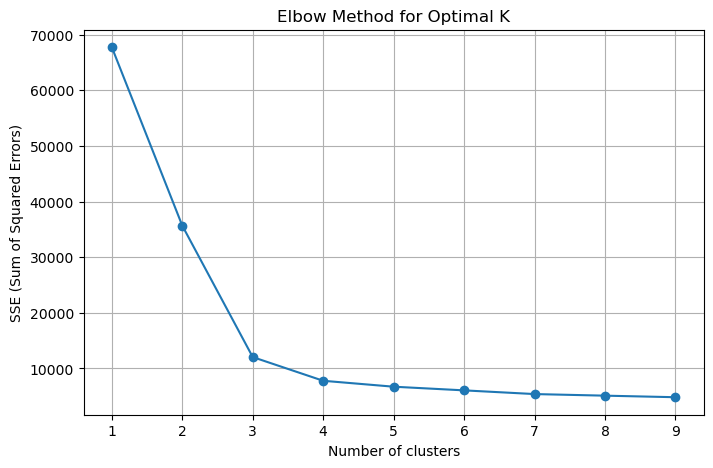

In [10]:
# Determine optimal number of clusters (K) using the Elbow method
sse = []  # Sum of squared errors for each K
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(to_plot)
    sse.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.grid(True)
plt.show()

In [ ]:
# Fit K-means with the optimal K
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(to_plot)

# Add the cluster labels to the original dataframe
data['Cluster'] = clusters

In [11]:
# calculate silhouette score to verify elbow score for optimal clusters
def calc_silhouette_score(X):
        range_clusters = [2, 3, 4, 5]
        for number_cluster in range_clusters:
            print(number_cluster)
            kmeans = KMeans(n_clusters=number_cluster, random_state= 123)
            y_cluster_labs = kmeans.fit_predict(X)
            silhouette_avg = silhouette_score(X, y_cluster_labs)
            print(silhouette_avg)
            
calc_silhouette_score(to_plot)

2
0.5278419771608357
3
0.6622846655861402
4
0.6281784928697821
5
0.504267275636057


In [12]:
# set optimal clusters to value found in silhouette score
optimal_k = 3 

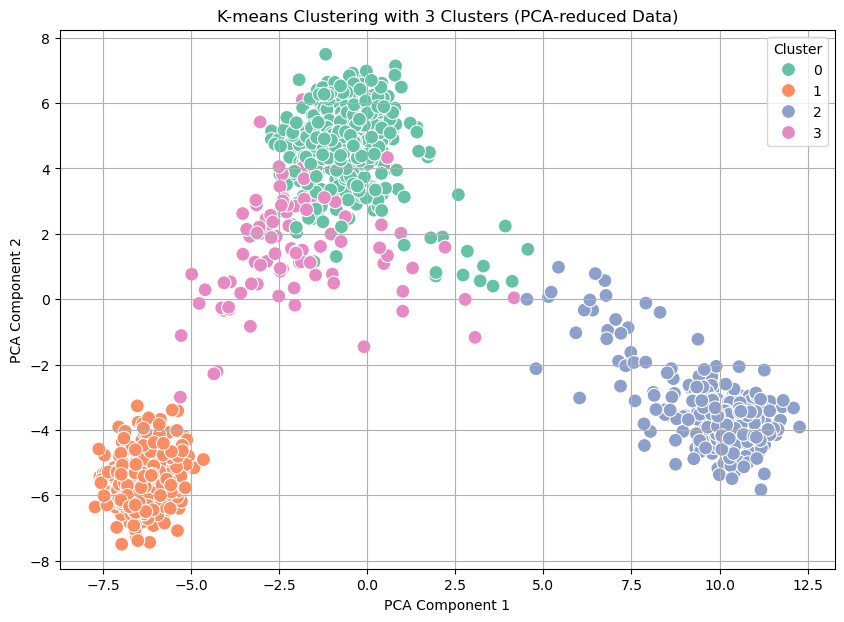

In [13]:
# Visualize clusters in PCA space (first two components)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=to_plot[:, 0], y=to_plot[:, 1], hue=data['Cluster'], palette='Set2', s=100)
plt.title(f'K-means Clustering with {optimal_k} Clusters (PCA-reduced Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


### Hierarchical Clustering

In [14]:
to_plot

array([[ 0.31282717,  5.35434925, -3.01058655,  0.06813242],
       [-0.67940259,  6.18332939, -1.82626467,  0.33816284],
       [-0.42071017,  5.2667196 , -0.67435308,  0.07191434],
       ...,
       [ 0.20043966,  4.43755038, -0.10550486, -1.38000881],
       [ 0.11973266,  4.95993686, -2.99905577,  1.59215495],
       [-0.28688807,  3.46617333,  0.84555809, -0.30691426]])

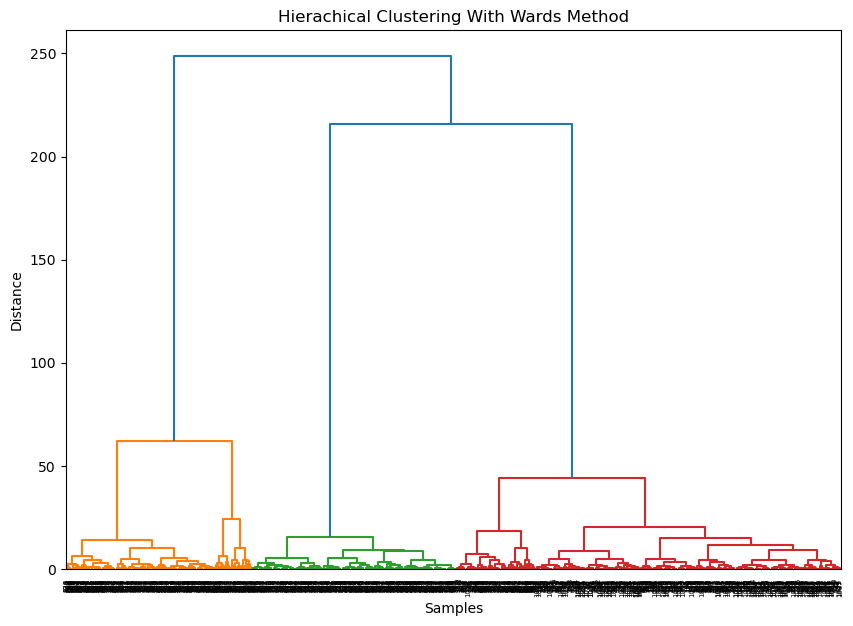

In [15]:
n = df_plot.drop(columns=['Population code', 'Sample'])
z = linkage(n, method= 'ward') # ward agglomerative clustering algorithm

plt.figure(figsize= (10, 7))
plt.title('Hierachical Clustering With Wards Method')
plt.xlabel('Samples')
plt.ylabel('Distance')
dendrogram(z, leaf_rotation= 90)
plt.show()

In [16]:
agg_clustering = AgglomerativeClustering(n_clusters= optimal_k, linkage='ward')
hieracrchy = agg_clustering.fit_predict(to_plot)

df_plot['Hierarchical_Cluster'] = hieracrchy

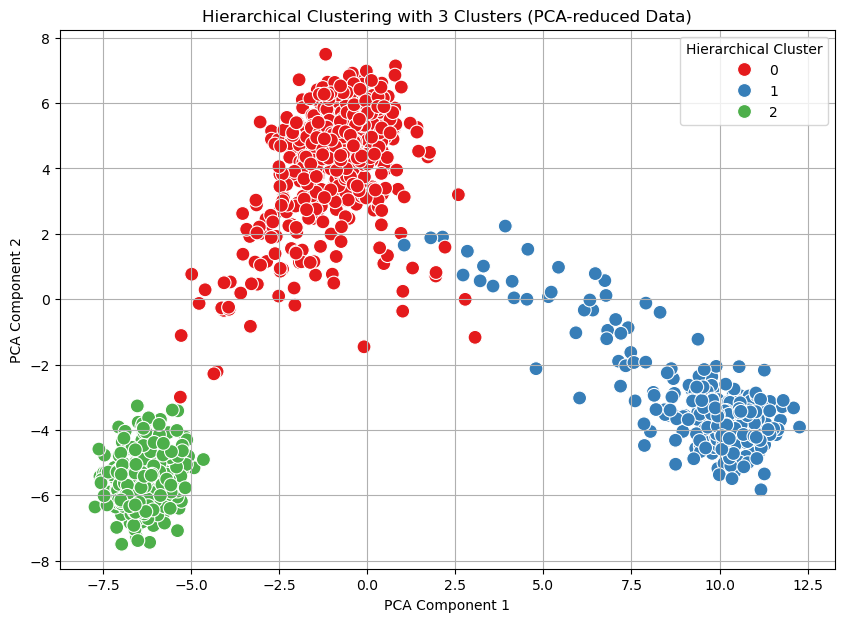

In [17]:
# Visualize Hierarchical Clustering results in PCA space
plt.figure(figsize=(10, 7))
sns.scatterplot(x=to_plot[:, 0], y=to_plot[:, 1], hue=df_plot['Hierarchical_Cluster'], palette='Set1', s=100)
plt.title(f'Hierarchical Clustering with {optimal_k} Clusters (PCA-reduced Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Hierarchical Cluster")
plt.grid(True)
plt.show()


In [18]:
# Compute Silhouette Score for Hierarchical Clustering
silhouette_avg_hierarchical = silhouette_score(to_plot, hieracrchy)
print(f'Silhouette Score for {optimal_k} Hierarchical Clusters: {silhouette_avg_hierarchical}')


Silhouette Score for 3 Hierarchical Clusters: 0.6547349670715849


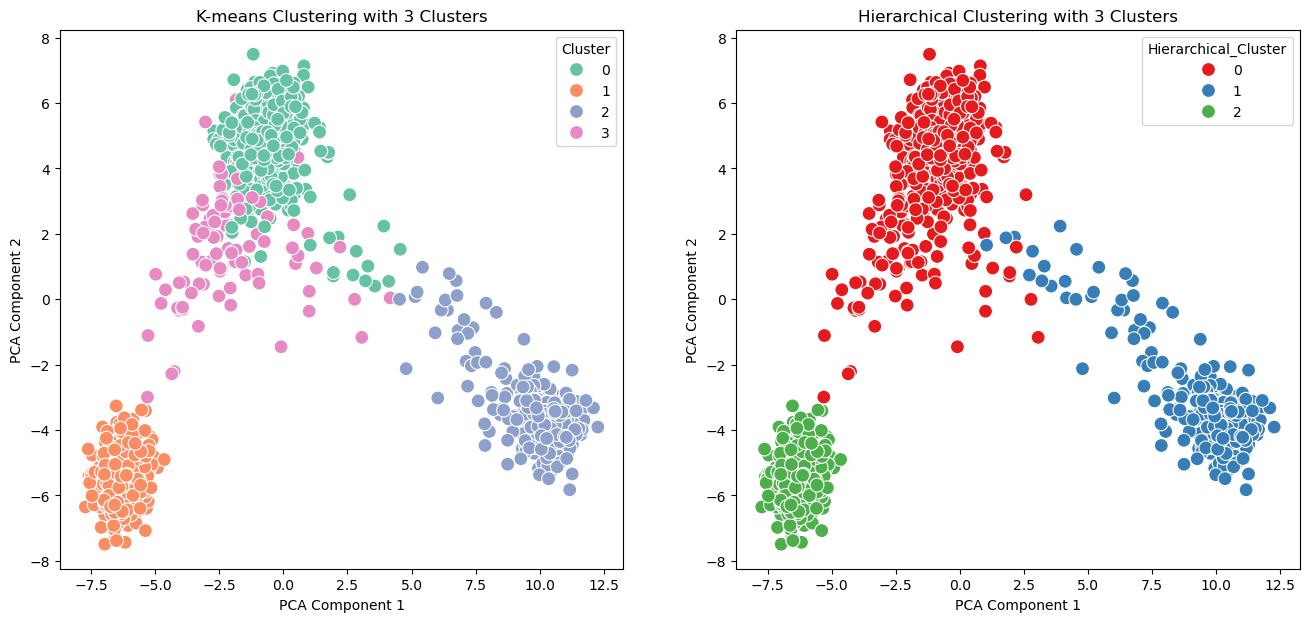

In [19]:
# Side-by-side comparison of K-means and Hierarchical clustering
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# K-means Clustering plot
sns.scatterplot(x=to_plot[:, 0], y=to_plot[:, 1], hue=data['Cluster'], palette='Set2', s=100, ax=ax[0])
ax[0].set_title(f'K-means Clustering with {optimal_k} Clusters')
ax[0].set_xlabel('PCA Component 1')
ax[0].set_ylabel('PCA Component 2')

# Hierarchical Clustering plot
sns.scatterplot(x=to_plot[:, 0], y=to_plot[:, 1], hue=df_plot['Hierarchical_Cluster'], palette='Set1', s=100, ax=ax[1])
ax[1].set_title(f'Hierarchical Clustering with {optimal_k} Clusters')
ax[1].set_xlabel('PCA Component 1')
ax[1].set_ylabel('PCA Component 2')

plt.show()


### tSNE 

In [20]:
X = matrix
X_embedded = TSNE(n_components=2 ,learning_rate= 'auto', init='random').fit_transform(X)
X_embedded.shape

(1092, 2)

In [21]:
df_plot['tsne1'] = X_embedded[:,0]
df_plot['tsne2'] = X_embedded[:,1]
df_plot.sample(5)

,Population code,Sample,PC1,PC2,Hierarchical_Cluster,tsne1,tsne2
635,JPT,NA18941,-6.321258,-5.631948,2,-35.307941,-6.837577
791,LWK,NA19324,10.256317,-3.132753,1,29.179905,-0.759771
447,CEU,NA12046,-1.233680,5.864435,0,2.675246,4.360558
158,FIN,HG00353,-1.065874,5.295882,0,5.269011,14.368574
533,CHB,NA18547,-5.792364,-6.575798,2,-36.335674,-6.966017


In [22]:
alt.Chart(df_plot).mark_point().encode(
    x='tsne1',
    y='tsne2',
    color=alt.Color('Population code', scale=alt.Scale(scheme='category20'))
)

/home/lewis/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/lewis/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### MLP

In [23]:
# Separate features (SNP data) and labels (Population labels)
X = df_plot.drop(columns=['Population code', 'Sample']).values
y = df_plot['Population code'].values

# Encode population labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.9, random_state=42)

# Standardize the SNP data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
import keras
import keras_tuner

In [25]:
def build_model(hp):
    model= keras.Sequential()
    model.add(keras.layers.Dense(
        hp.Choice('units', [8,16,32]),
        activation = 'relu'))
    model.add(keras.layers.Dense(1, activation='relu'))
    model.compile(loss='mse')
    return model
    

In [26]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective= 'val_loss',
    max_trials = 5
)

Reloading Tuner from ./untitled_project/tuner0.json


In [27]:
from tensorflow.keras.layers import Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers

In [28]:

# Define a function to create the model
def build_model(hp):
    model = keras.Sequential()

    # Tune the number of neurons in the first Dense layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units1, activation='relu', input_shape=(X_train_scaled.shape[1],)))

    # Optional hidden layers: Tune the number of hidden layers and their size
    for i in range(hp.Int('num_layers', 1, 3)):  # 1 to 3 layers
        hp_units = hp.Int(f'units_{i+2}', min_value=32, max_value=512, step=32)
        model.add(layers.Dense(units=hp_units, activation='relu'))

    # Tune dropout layer to prevent overfitting
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    model.add(layers.Dropout(rate=hp_dropout))

    # Output layer with softmax for multi-class classification
    model.add(layers.Dense(len(np.unique(y_encoded)), activation='softmax'))

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model


In [29]:
from keras_tuner.tuners import RandomSearch

# Initialize the Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=20,             # Number of different hyperparameter sets to try
    executions_per_trial=2,     # How many times to run each model
    directory='tuner_results',  # Save the results in this directory
    project_name='population_genetics_tuning')  # Project name


Reloading Tuner from tuner_results/population_genetics_tuning/tuner0.json


In [30]:
# Search for the best hyperparameters
tuner.search(X_train_scaled, y_train, 
             validation_split=0.2, 
             epochs=50, 
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])


In [31]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best number of units in first Dense layer: {best_hps.get('units1')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best number of layers: {best_hps.get('num_layers')}")
print(f"Best dropout rate: {best_hps.get('dropout')}")


Best number of units in first Dense layer: 352
Best learning rate: 0.01
Best number of layers: 1
Best dropout rate: 0.30000000000000004


In [32]:
early_stopping = EarlyStopping(patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor= 0.5, patience = 5, min_lr =0.00001)

In [33]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the final model
history = model.fit(X_train_scaled, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10), reduce_lr])


Epoch 1/50


/home/lewis/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.0982 - loss: 2.4276 - val_accuracy: 0.3636 - val_loss: 1.7423 - learning_rate: 0.0100
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3075 - loss: 1.7423 - val_accuracy: 0.4091 - val_loss: 1.3003 - learning_rate: 0.0100
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3965 - loss: 1.4129 - val_accuracy: 0.3182 - val_loss: 1.3285 - learning_rate: 0.0100
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3422 - loss: 1.4353 - val_accuracy: 0.4545 - val_loss: 1.2249 - learning_rate: 0.0100
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4661 - loss: 1.2522 - val_accuracy: 0.5000 - val_loss: 1.1352 - learning_rate: 0.0100
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4273 - loss: 1.1717 - val_accuracy: 0.3636 - val_loss: 1.1278 - learning_rate: 0.0100
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4987 - loss: 1.1005 - val_accuracy: 0.4091 - val_loss

In [34]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4751 - loss: 1.6678 
Test Accuracy: 0.48626652359962463


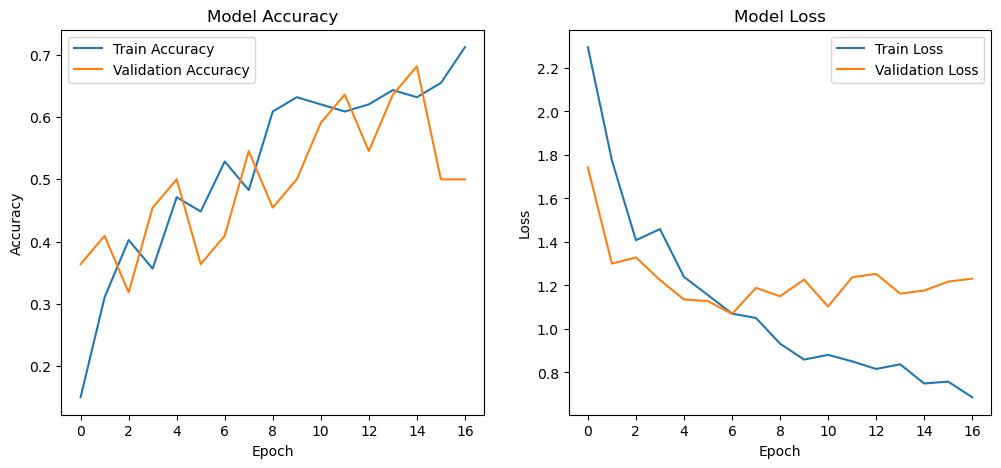

In [38]:
# Plot training & validation accuracy and loss over epochs
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.34      0.49        58
           1       0.00      0.00      0.00        77
           2       0.50      0.13      0.21        90
           3       0.44      0.31      0.37        89
           4       0.50      0.47      0.49        53
           5       0.49      0.61      0.55        83
           6       0.25      0.38      0.31        78
           7       0.00      0.00      0.00        13
           8       0.41      0.88      0.56        81
           9       0.81      0.79      0.80        84
          10       0.68      0.81      0.74        62
          11       0.50      0.20      0.29        50
          12       0.30      0.48      0.37        87
          13       0.65      0.94      0.76        78

    accuracy                           0.49       983
   macro avg       0.46      0.45      0.42       983
weighted avg     

/home/lewis/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lewis/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lewis/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


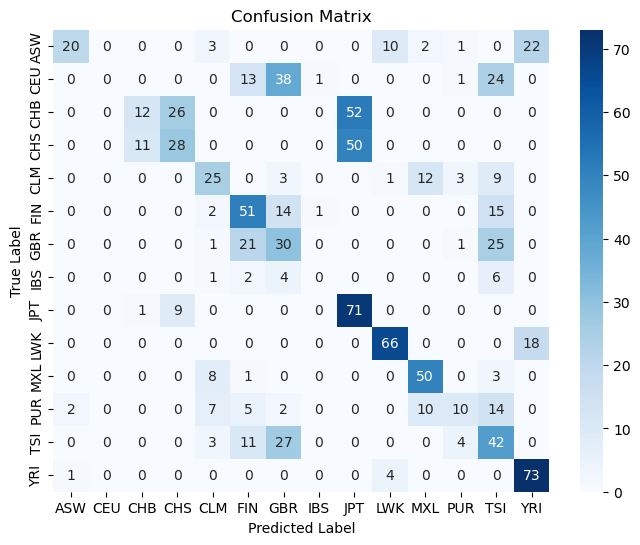

In [39]:
# Predict population labels for the test set
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [41]:
from sklearn.model_selection import KFold

# Set up KFold Cross-Validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store the accuracy for each fold
fold_accuracies = []

# Iterate over each fold
for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Build a new model for each fold
    model = build_model(best_hps)
    
    # Fit the model on the current fold
    model.fit(X_train_fold, y_train_fold, 
              epochs=50, 
              batch_size=32, 
              validation_data=(X_val_fold, y_val_fold),
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
              verbose=0)  # Set verbose=1 to view training logs
    
    # Evaluate on the validation set
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=1)
    fold_accuracies.append(val_accuracy)

# Calculate the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f'Average accuracy across {k} folds: {average_accuracy}')


/home/lewis/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7727 - loss: 0.5835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8182 - loss: 0.5768
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9091 - loss: 0.4071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6364 - loss: 0.8910
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9048 - loss: 0.4998
Average accuracy across 5 folds: 0.8082251071929931
